In [1]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import anndata as ad
import episcanpy.api as epi
import scanpy as sc
from scipy.sparse import csc_matrix

import os

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns



def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))

    
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.



In [2]:
%%R -o features -o cells -o mtx
df_count = readRDS('./input/erythropoiesis_noisy_p4.rds')
mtx=as.matrix(df_count)
features = df_count@Dimnames[[1]]
cells = df_count@Dimnames[[2]]

R[write to console]: Loading required package: Matrix



In [3]:
# format the data
mtx=csc_matrix(mtx).transpose()
cells = cells.tolist()
features = features.tolist()

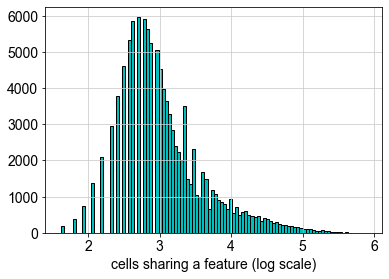

AnnData object with n_obs × n_vars = 1200 × 109858 
    obs: 'cell_type', 'n_features', 'nb_features'
    var: 'n_cells', 'commonness'


... storing 'cell_type' as categorical


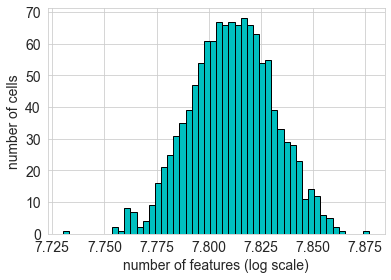

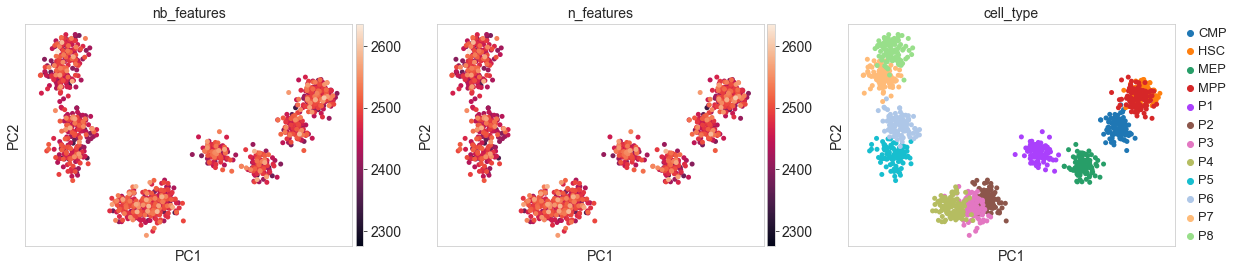

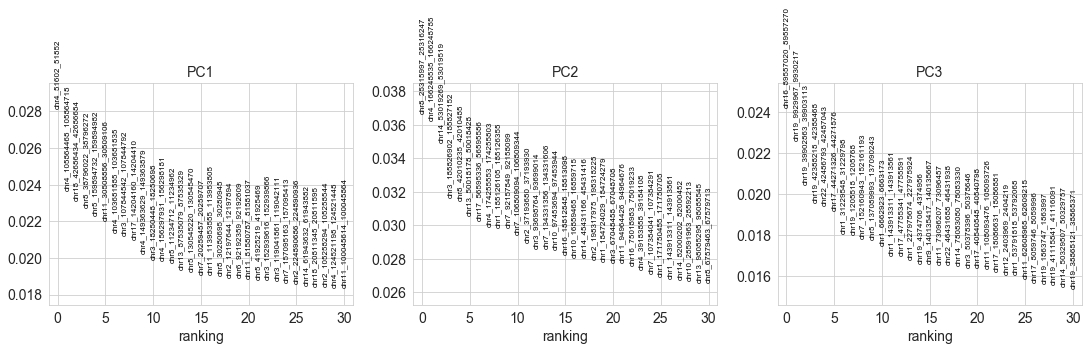

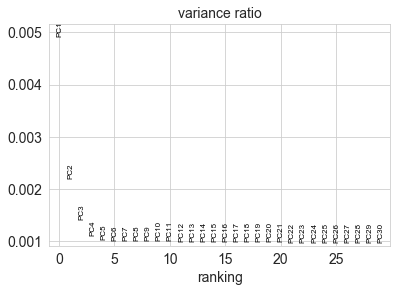

In [4]:
adata = ad.AnnData(mtx,
                   obs=pd.DataFrame(index=cells),
                   var=pd.DataFrame(index=features))

# load metadata
metadata = pd.read_csv('./input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label']))
adata.obs['cell_type'] = metadata['label']

epi.pp.binarize(adata)
#print(adata)

#epi.pp.commonness_features(adata, binary=True)
#epi.pp.coverage_cells(adata, binary=True)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=5)

#epi.pp.select_var_feature(adata, nb_features=100000)

epi.pp.commonness_features(adata, binary=True, log=True)
epi.pp.coverage_cells(adata, binary=True, log=True)

sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=False,
                                      max_fraction=0.05, key_added=None, layers=None,
                                      layer_norm=None, inplace=True)

sc.pp.log1p(adata)

#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)
#adata = adata[:, adata.var['highly_variable']]
print(adata)

adatareduced = adata.copy()
epi.pp.pca(adatareduced, n_comps=30)
sc.pl.pca_overview(adatareduced, color=['nb_features', 'n_features', 'cell_type'])

In [5]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

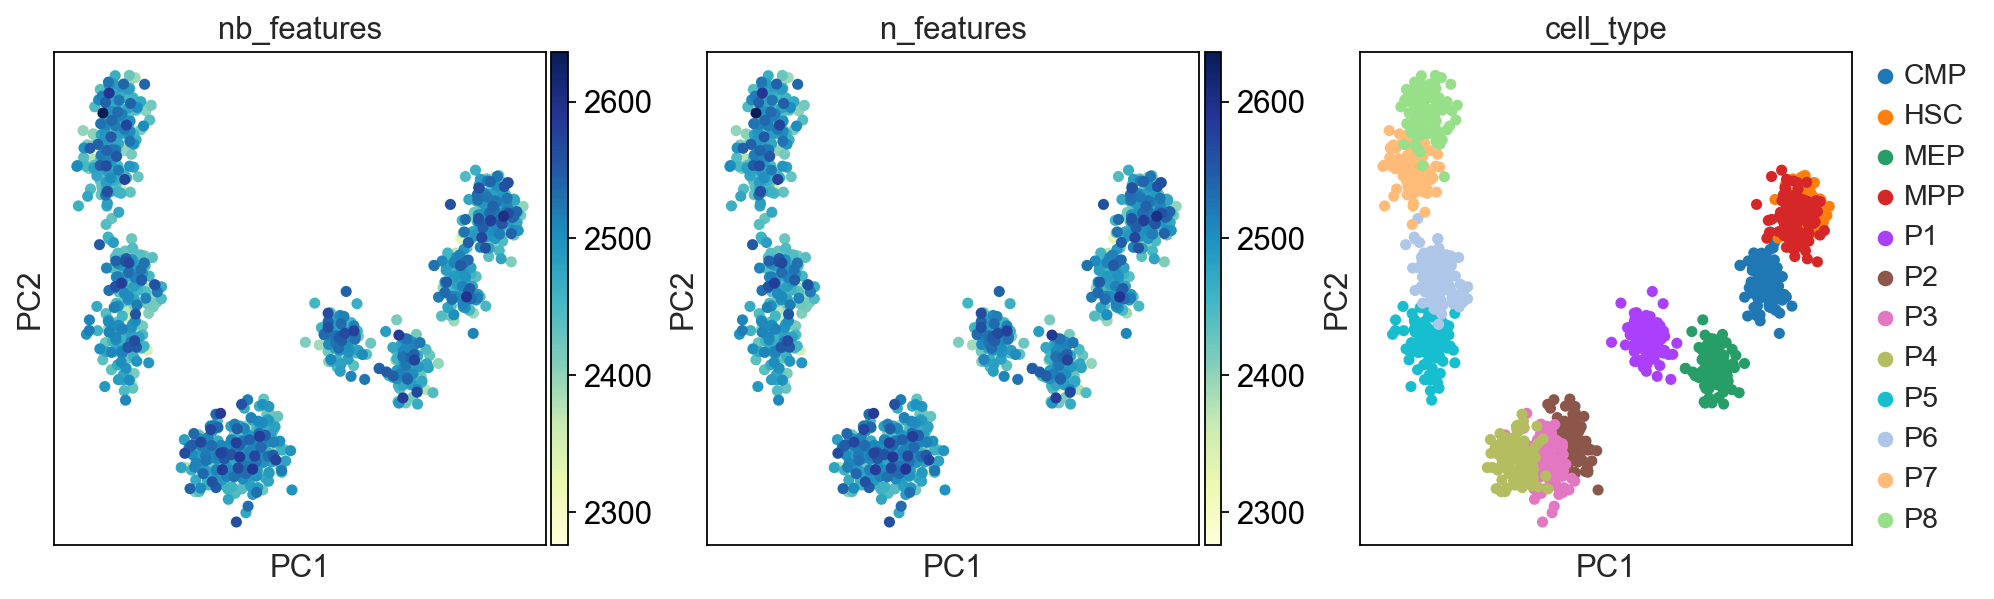

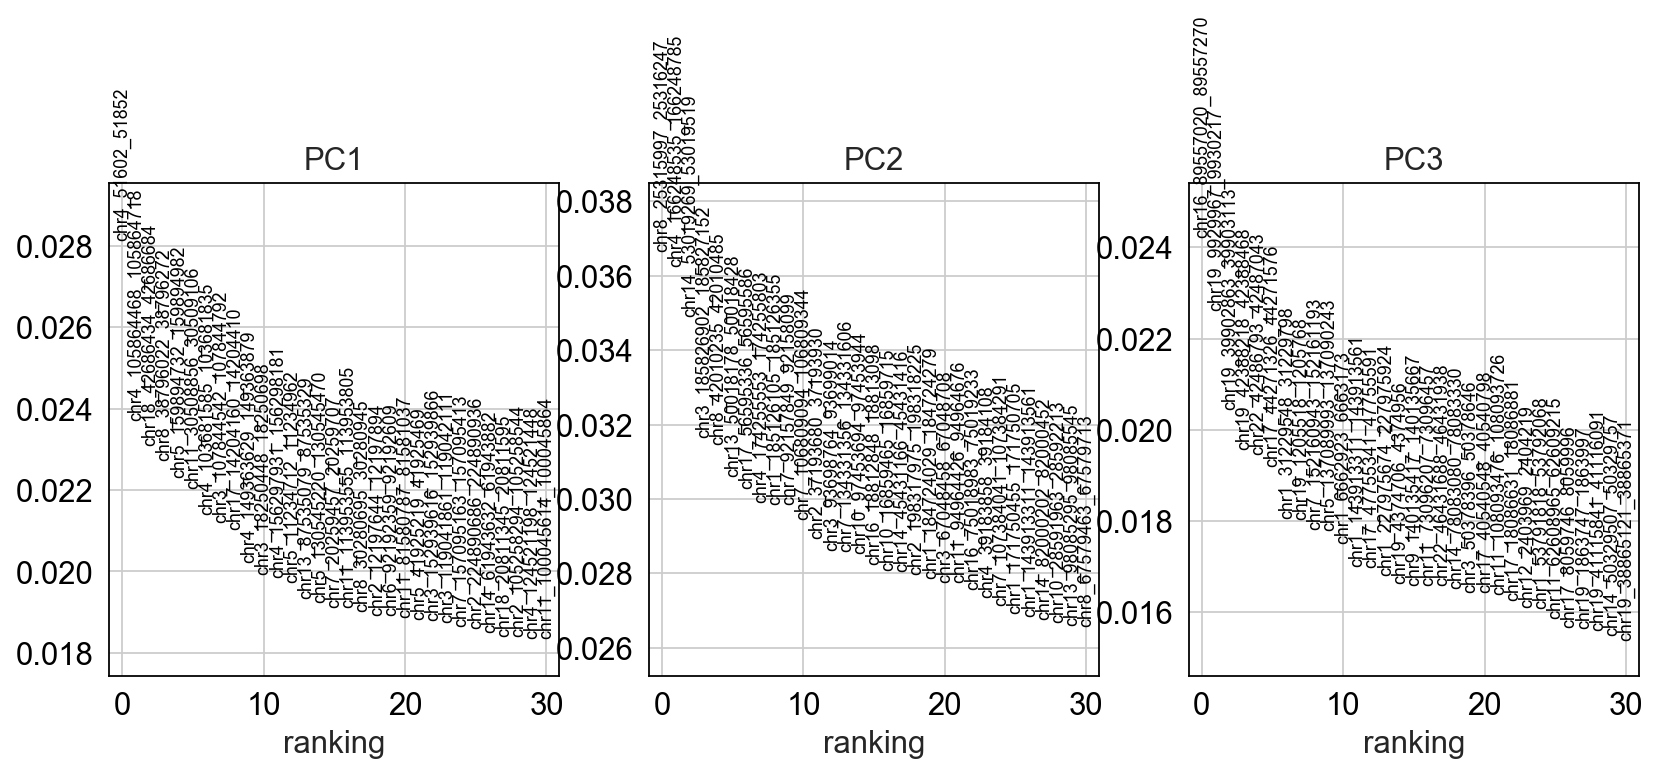

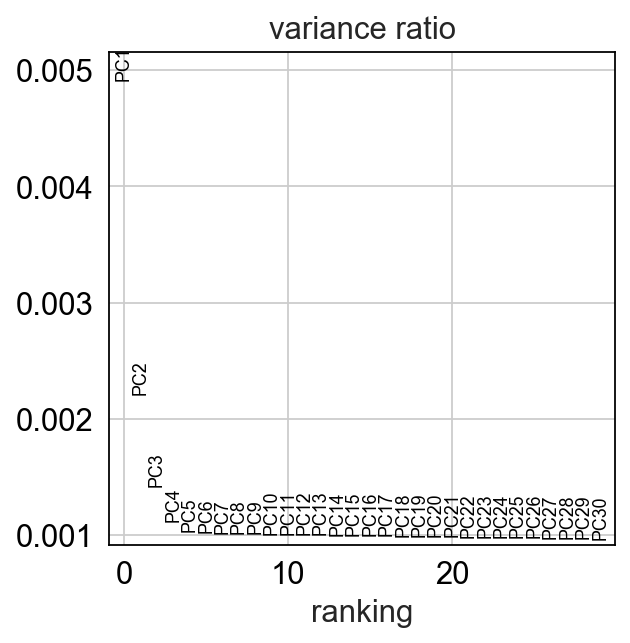

In [6]:
sc.pl.pca_overview(adatareduced, color=['nb_features', 'n_features', 'cell_type'])

step 0
got 14 at resolution 1.5
step 1
got 11 at resolution 0.75
step 2
got 11 at resolution 1.125
step 3


... storing 'cell_type' as categorical
... storing 'label' as categorical


got 12 at resolution 1.3125


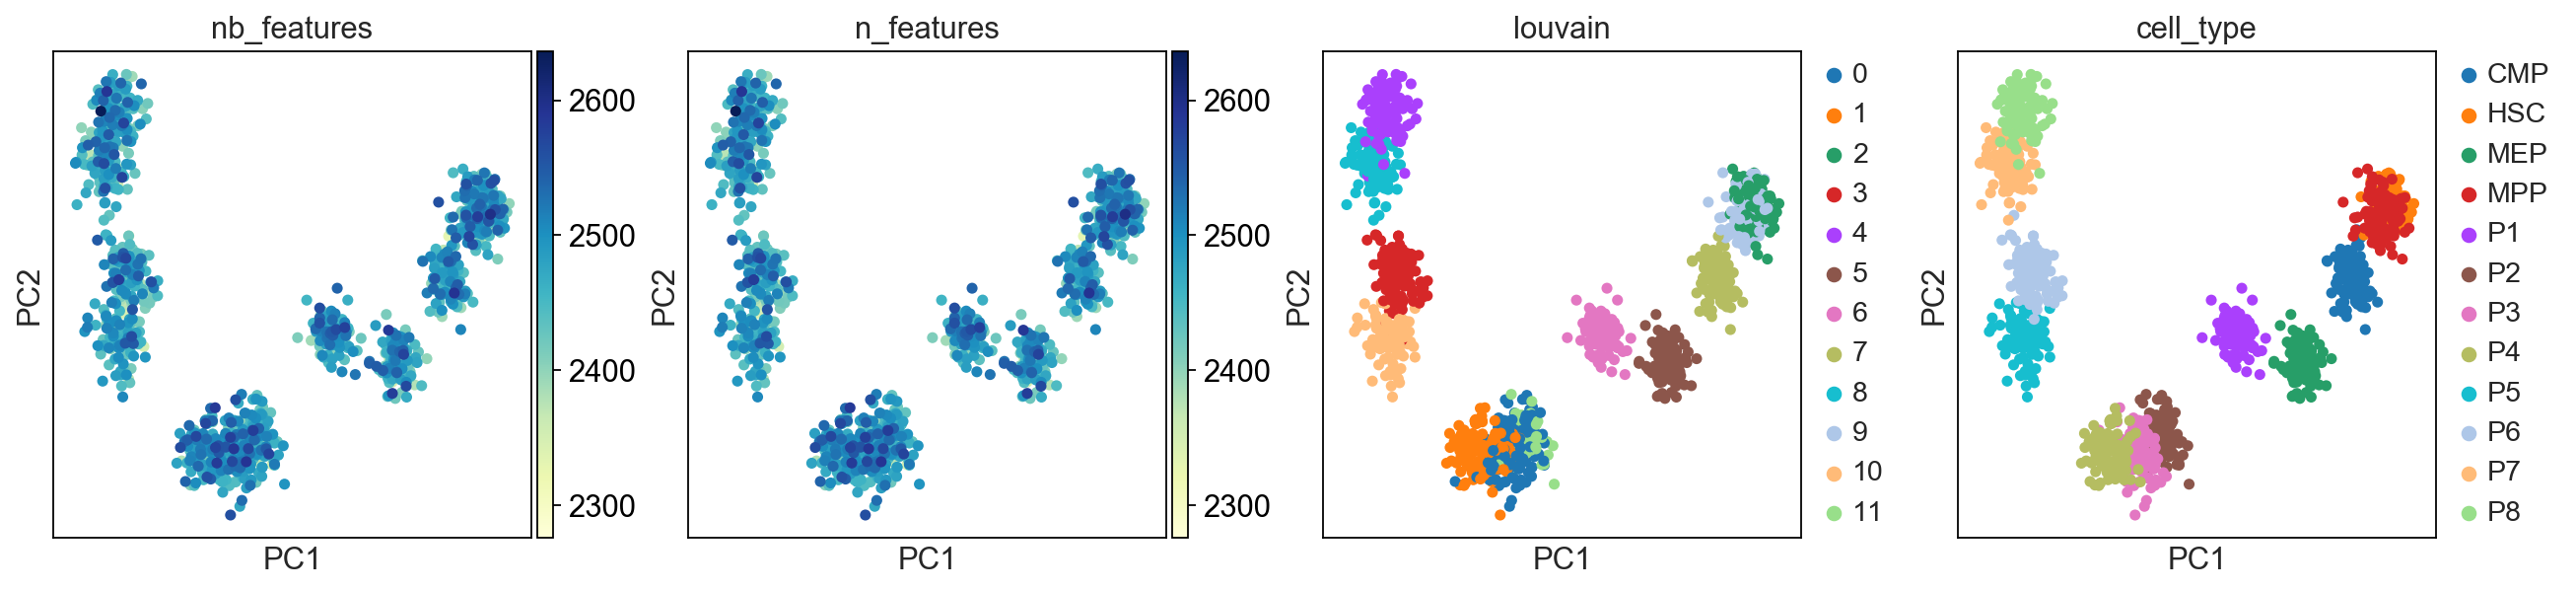

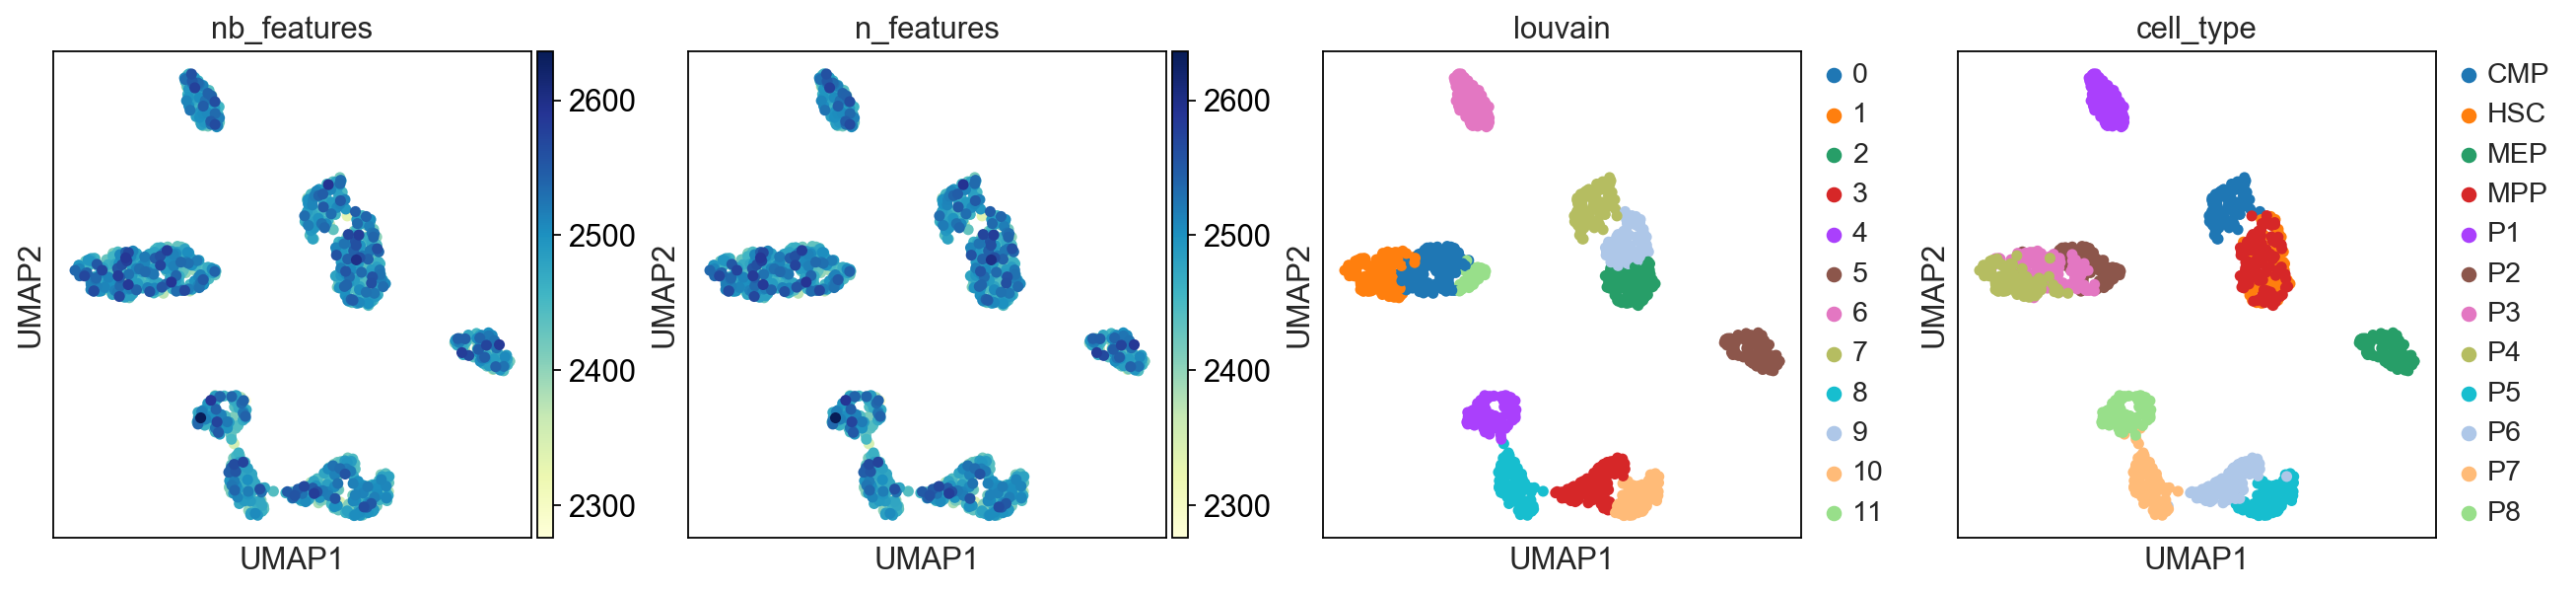

0.7561539315606416 0.7465153558134268 0.7554476962835899


In [7]:
adatareduced = adata.copy()
# convert the cell label to standard label
adatareduced.obs['label'] = adatareduced.obs['cell_type']


epi.pp.pca(adatareduced, n_comps=3)
sc.pp.neighbors(adatareduced, n_neighbors=15)
epi.tl.umap(adatareduced)
#epi.tl.louvain(adatareduced)
getNClusters(adatareduced,n_cluster=num_clusters)
#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['kmeans'] = pd.Series(kmeans.labels_,index=adatareduced.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['hc'] = pd.Series(hc.labels_,index=adatareduced.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
ari_kmeans = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
ari_hc = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['hc'])

sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])
sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

print(ari_louvain, ari_kmeans, ari_hc)

0.7561539315606416
step 0
got 14 at resolution 1.5
step 1
got 11 at resolution 0.75
step 2
got 11 at resolution 1.125
step 3
got 12 at resolution 1.3125


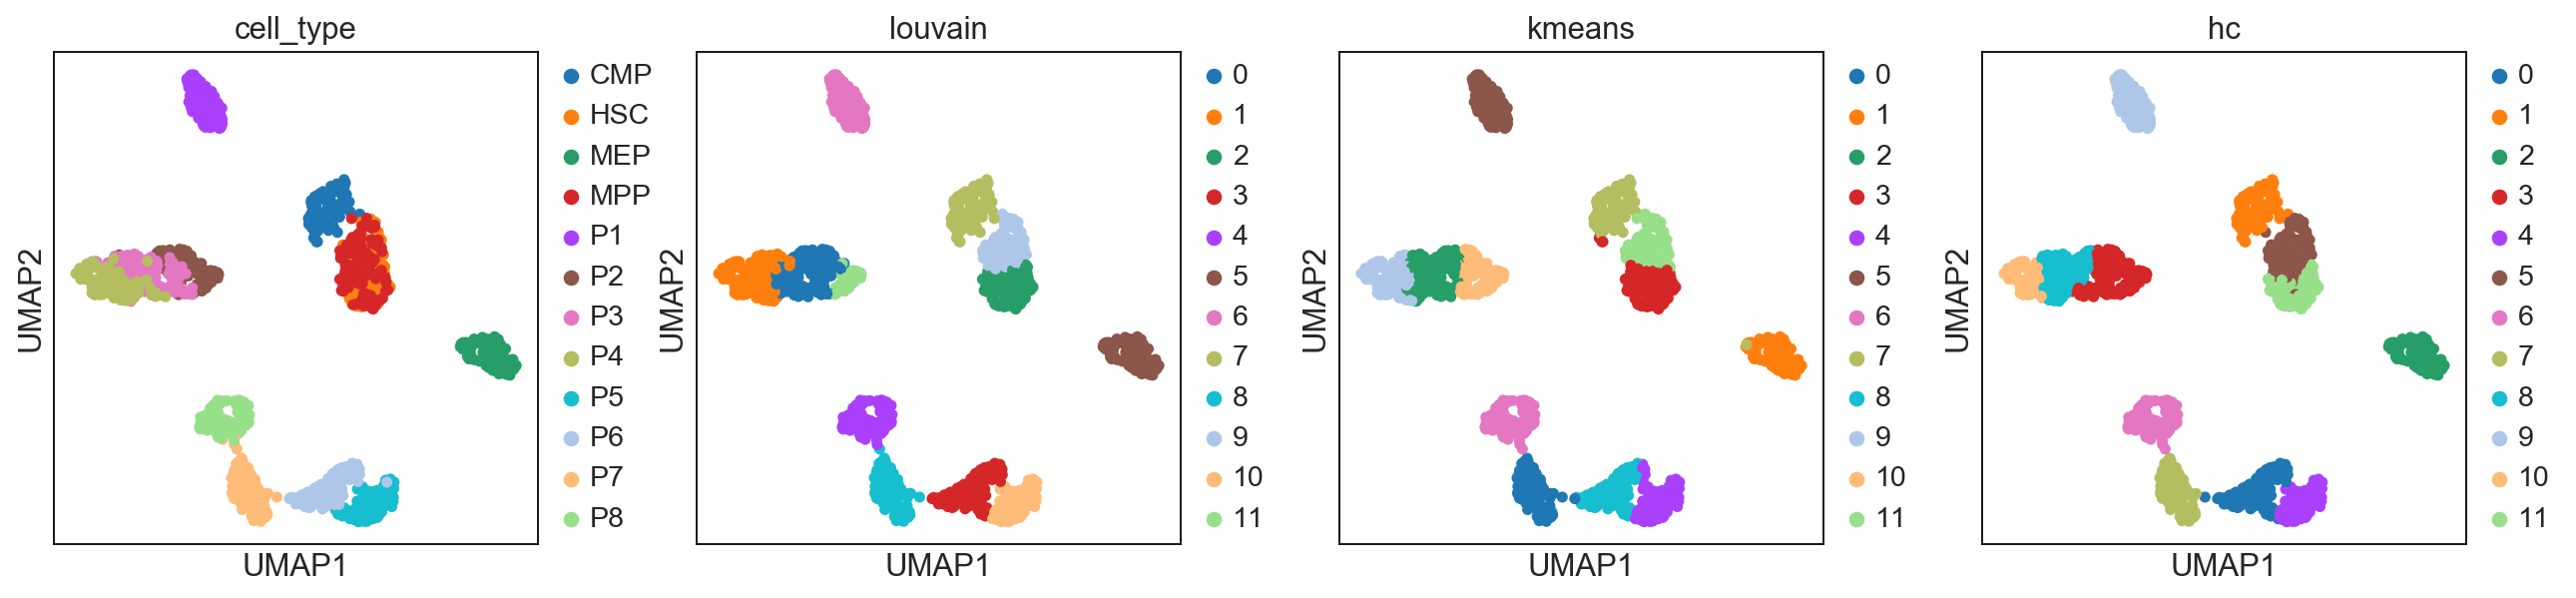

['BROCKMAN', '0.641155', '0.532434', '0.576959', '0.784956', '0.73782', '0.758699', '0.78375', '0.736047', '0.756478']
['Cusanovich2018', '0.692886', '0.592626', '0.618372', '0.814455', '0.787994', '0.771733', '0.817862', '0.777585', '0.760077']
['cisTopic', '0.721536', '0.720576', '0.654783', '0.824928', '0.838678', '0.784448', '0.826919', '0.835139', '0.787615']
['chromVAR_kmers', '0.392939', '0.362402', '0.375366', '0.552959', '0.565858', '0.539151', '0.54188', '0.562366', '0.542549']
['chromVAR_motifs', '0.177749', '0.212574', '0.167491', '0.359959', '0.4059', '0.325384', '0.364856', '0.415697', '0.337029']
['chromVAR_kmers_pca', '0.407467', '0.405397', '0.3525', '0.554217', '0.583439', '0.53764', '0.547964', '0.590954', '0.541055']
['chromVAR_motifs_pca', '0.214423', '0.184863', '0.151007', '0.394982', '0.374467', '0.324611', '0.399325', '0.386423', '0.334291']
['GeneScoring', '0.00284294', '0.1755', '0.175657', '0.00441611', '0.289236', '0.282009', '0.0252127', '0.266834', '0.279

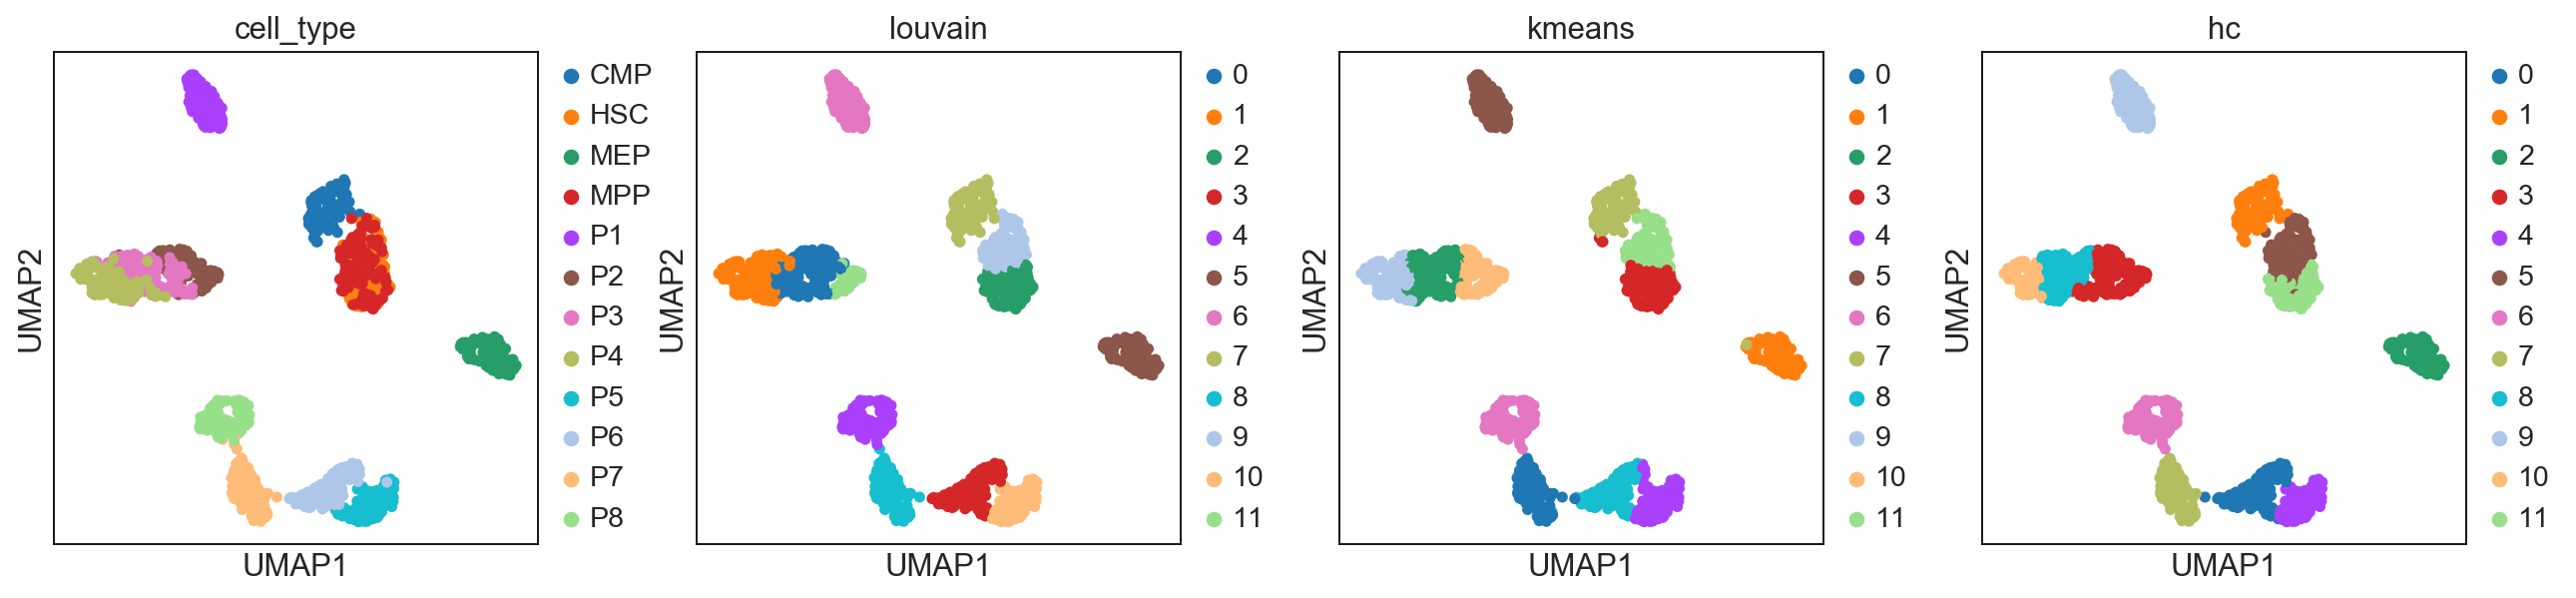

,ARI_Louvain,ARI_kmeans,ARI_HC,AMI_Louvain,AMI_kmeans,AMI_HC,Homogeneity_Louvain,Homogeneity_kmeans,Homogeneity_HC,method
epiScanpy-adata,0.756154,0.746515,0.755448,0.861605,0.846057,0.853522,0.859477,0.848962,0.855125,epiScanpy-adata
BROCKMAN,0.641155,0.532434,0.576959,0.784956,0.737820,0.758699,0.783750,0.736047,0.756478,BROCKMAN
Cusanovich2018,0.692886,0.592626,0.618372,0.814455,0.787994,0.771733,0.817862,0.777585,0.760077,Cusanovich2018
cisTopic,0.721536,0.720576,0.654783,0.824928,0.838678,0.784448,0.826919,0.835139,0.787615,cisTopic
chromVAR_kmers,0.392939,0.362402,0.375366,0.552959,0.565858,0.539151,0.541880,0.562366,0.542549,chromVAR_kmers
chromVAR_motifs,0.177749,0.212574,0.167491,0.359959,0.405900,0.325384,0.364856,0.415697,0.337029,chromVAR_motifs
chromVAR_kmers_pca,0.407467,0.405397,0.352500,0.554217,0.583439,0.537640,0.547964,0.590954,0.541055,chromVAR_kmers_pca
chromVAR_motifs_pca,0.214423,0.184863,0.151007,0.394982,0.374467,0.324611,0.399325,0.386423,0.334291,chromVAR_motifs_pca
GeneScoring,0.002843,0.175500,0.175657,0.004416,0.289236,0.282009,0.025213,0.266834,0.279538,GeneScoring
GeneScoring_pca,0.149945,0.184965,0.197432,0.327187,0.334777,0.346130,0.334635,0.338750,0.346018,GeneScoring_pca


In [ ]:
############ Benchmarking
all_metrics = """Control	0.65972	0.636097	0.591576	0.79335	0.780363	0.756768	0.789569	0.77741	0.7553
BROCKMAN	0.641155	0.532434	0.576959	0.784956	0.73782	0.758699	0.78375	0.736047	0.756478
Cusanovich2018	0.692886	0.592626	0.618372	0.814455	0.787994	0.771733	0.817862	0.777585	0.760077
cisTopic	0.721536	0.720576	0.654783	0.824928	0.838678	0.784448	0.826919	0.835139	0.787615
chromVAR_kmers	0.392939	0.362402	0.375366	0.552959	0.565858	0.539151	0.54188	0.562366	0.542549
chromVAR_motifs	0.177749	0.212574	0.167491	0.359959	0.4059	0.325384	0.364856	0.415697	0.337029
chromVAR_kmers_pca	0.407467	0.405397	0.3525	0.554217	0.583439	0.53764	0.547964	0.590954	0.541055
chromVAR_motifs_pca	0.214423	0.184863	0.151007	0.394982	0.374467	0.324611	0.399325	0.386423	0.334291
GeneScoring	0.00284294	0.1755	0.175657	0.00441611	0.289236	0.282009	0.0252127	0.266834	0.279538
GeneScoring_pca	0.149945	0.184965	0.197432	0.327187	0.334777	0.34613	0.334635	0.33875	0.346018
Cicero	-0.000142554	0.242909	0.308266	0.000938386	0.454503	0.477417	0.0218704	0.376673	0.453725
Cicero_pca	0.293574	0.262829	0.234186	0.47036	0.433284	0.421939	0.461548	0.433776	0.40749
SnapATAC	0.847829	0.846591	0.815399	0.907737	0.906247	0.894752	0.907918	0.90812	0.895495
Scasat	0.626085	0.647375	0.615576	0.770045	0.785213	0.761184	0.767963	0.783016	0.758848
scABC	0.341578	0.27842	0.402747	0.509823	0.549059	0.589272	0.471725	0.415121	0.572294
SCRAT	0.551589	0.488487	0.479701	0.728861	0.703775	0.706105	0.728487	0.70234	0.700959
SCRAT_pca	0.537457	0.516056	0.512602	0.72096	0.718026	0.720016	0.719459	0.718332	0.716091
"""


adata = adatareduced.copy()

from sklearn.metrics import adjusted_rand_score

labels_true = adata.obs['cell_type']
labels_pred = adata.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))


    
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])


# set method name
method = 'epiScanpy-adata'

# convert the cell label to standard label
adata.obs['label'] = adata.obs['cell_type']

# set the number of cluster for louvain
num_clusters = len(np.unique(adata.obs['label']))
#print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adata,n_cluster=num_clusters)

#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = pd.Series(kmeans.labels_,index=adata.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.obsm['X_pca'])
adata.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adata.obs['label'], adata.obs['louvain'])
ari_kmeans = adjusted_rand_score(adata.obs['label'], adata.obs['kmeans'])
ari_hc = adjusted_rand_score(adata.obs['label'], adata.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adata.obs['label'], adata.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adata.obs['label'], adata.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adata.obs['label'], adata.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adata.obs['label'], adata.obs['louvain'])
homo_kmeans = homogeneity_score(adata.obs['label'], adata.obs['kmeans'])
homo_hc = homogeneity_score(adata.obs['label'], adata.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics[1:]:
    print(line)
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


for key in df_metrics.keys():
    df_metrics[key] = [float(key) for key in df_metrics[key]]
    
df_metrics['method'] = df_metrics.index.tolist()


sns.set(style="whitegrid")

# data to plot
df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values('ARI_kmeans',
                                        ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

df_metrics

In [8]:
# data to plot
df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values("ARI_Louvain",
                                        ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

df_metrics

NameError: name 'df_metrics' is not defined